In [2]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap


## Cargo Dataset principal

In [3]:
df = pd.read_csv('../../data/Top100_prediction_con.csv')

In [7]:
df.head()

,Unnamed: 0,id,store,date,sales,item,store_code,yearweek,sell_price,weekday,event,income
0,103,ACCESORIES_1_108_NYC_1,Greenwich_Village,2011-01-29,4,ACCESORIES_1_108,NYC_1,201105,16.1196,Saturday,0.0,64.4784
1,591,HOME_&_GARDEN_1_027_NYC_1,Greenwich_Village,2011-01-29,4,HOME_&_GARDEN_1_027,NYC_1,201105,6.5500,Saturday,0.0,26.2000
2,615,HOME_&_GARDEN_1_053_NYC_1,Greenwich_Village,2011-01-29,0,HOME_&_GARDEN_1_053,NYC_1,201105,18.7125,Saturday,0.0,0.0000
3,700,HOME_&_GARDEN_1_140_NYC_1,Greenwich_Village,2011-01-29,4,HOME_&_GARDEN_1_140,NYC_1,201105,18.7500,Saturday,0.0,75.0000
4,737,HOME_&_GARDEN_1_177_NYC_1,Greenwich_Village,2011-01-29,0,HOME_&_GARDEN_1_177,NYC_1,201105,9.9625,Saturday,0.0,0.0000


In [4]:
df_original = df.copy()
df_filtrado = df_original[(df_original['store_code'] == 'BOS_1') & (df_original['item'] == 'SUPERMARKET_3_090')]

In [9]:
ts_predict = df_filtrado[['date', 'income', 'weekday', 'event']]
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.sort_values('date', ascending=True, inplace=True)
ts_predict.set_index('date', inplace=True)
ts_predict = ts_predict.asfreq('D')
y, exog = ts_predict['income'], ts_predict.drop(columns=['income'])
y_train, y_test = y[:-30], y[-30:]
exog_train, exog_test = exog[:-30], exog[-30:]

In [10]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(),
        lags=14
    )

forecaster.fit(y=y_train)

predicciones = forecaster.predict(steps=30)

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [11]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")

rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

Test error (MSE): 680.5640958028803
El error RMSPE es: 24.88%


In [12]:
result = pd.DataFrame(predicciones)
result['test']= y_test

In [26]:
result

,pred,test
2016-03-26,64.13,67
2016-03-27,63.59,113
2016-03-28,44.11,36
2016-03-29,43.92,35
2016-03-30,42.05,43
2016-03-31,50.84,57
2016-04-01,58.03,44
2016-04-02,60.29,81
2016-04-03,56.46,67
2016-04-04,48.33,56


## CON HIPERPARAMETROS SIN EXOGENAS

In [13]:
# Hyperparameters: grid search
# ==============================================================================
steps = 14
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 7 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [3,4,5,7,8,10,14]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = y_train,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(y_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 28.


lags grid: 100%|██████████| 7/7 [07:46<00:00, 66.66s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 3220.2706945470536



/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [15]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=10,
                                        max_depth=3,
                                        #min_samples_leaf=2, 
                                        #min_samples_split=5,
                                        n_estimators=250),
        lags=14
    )

forecaster.fit(y=y_train)

predicciones = forecaster.predict(steps=30)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")

rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Test error (MSE): 919.3605220434499
El error RMSPE es: 27.72%


In [16]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,93.473865,120.6
2016-03-27,100.843957,203.4
2016-03-28,91.234561,64.8
2016-03-29,89.670641,63.0
2016-03-30,89.574213,77.4
2016-03-31,89.775443,102.6
2016-04-01,110.648462,79.2
2016-04-02,90.145226,145.8
2016-04-03,95.261071,120.6
2016-04-04,90.062785,100.8


In [17]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=11),
        lags=14
    )

forecaster.fit(y=y_train, exog=exog_train)

predicciones = forecaster.predict(steps=30, exog=exog_test)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")

rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Test error (MSE): 443.85447463392
El error RMSPE es: 18.25%


In [18]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,120.39996,120.6
2016-03-27,123.20124,203.4
2016-03-28,80.80992,64.8
2016-03-29,71.34732,63.0
2016-03-30,78.72912,77.4
2016-03-31,88.91664,102.6
2016-04-01,98.72148,79.2
2016-04-02,118.19136,145.8
2016-04-03,114.30132,120.6
2016-04-04,81.51888,100.8


In [19]:
# Definir el modelo con un regressor base
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=42),
    lags=7  # Esta es solo una configuración inicial, la ajustaremos con GridSearch
)

# Parámetros del RandomForest y los lags a buscar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2],  # Muestras mínimas en una hoja
}

lags_grid = [7, 14, 21, 30]

# Realizar el GridSearch
results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=y_train,  # Serie temporal de entrenamiento
    exog=exog_train,  # Variables exógenas si tienes alguna
    param_grid=param_grid,  # La cuadrícula de parámetros
    lags_grid=lags_grid,
    steps=7,  # Cuántos pasos (días) predecir hacia adelante
    metric='mean_squared_error',  # Métrica de evaluación (también puede ser MAE, etc.)
    initial_train_size=len(y_train) - 30,  # Tamaño inicial de la ventana de entrenamiento
    refit=True,  # Reentrenar el modelo en cada combinación de hiperparámetros
    return_best=True,  # Devolver el mejor modelo
    verbose=True
)

# Mostrar los mejores parámetros y el error
print(f"Mejores parámetros: {results_grid}")
print(f"Mejor RMSE: {results_grid['mean_squared_error'].min()}")


Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  25%|██▌       | 1/4 [04:01<12:03, 241.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  50%|█████     | 2/4 [08:57<09:07, 273.84s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  75%|███████▌  | 3/4 [13:47<04:40, 280.83s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid: 100%|██████████| 4/4 [20:13<00:00, 303.45s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
  Backtesting metric: 658.0679637318843

Mejores parámetros:                                                lags  \
33                            [1, 2, 3, 4, 5, 6, 7]   
69  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
61  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
66  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
63  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
..                                              ...   
4                             [1, 2, 3, 4, 5, 6, 7]   
7                             [1, 2, 3, 4, 5, 6, 7]   
10                            [1, 2, 3, 4, 5, 6, 7]   
36  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
1                             [1, 2, 3, 4, 5, 6, 7]   

                                         lags_label  \
33        

In [20]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=10,
                                        max_depth=10,
                                        min_samples_leaf=2, 
                                        min_samples_split=5,
                                        n_estimators=50),
        lags=7
    )

forecaster.fit(y=y_train, exog=exog_train)

predicciones = forecaster.predict(steps=30,exog=exog_test)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")
rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

print(f'El error RMSPE es: {rmspe:.2f}%')

Test error (MSE): 374.1265816986876
El error RMSPE es: 18.96%


In [42]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,61.084405,67
2016-03-27,70.267286,113
2016-03-28,41.432048,36
2016-03-29,43.800524,35
2016-03-30,42.226000,43
2016-03-31,51.304048,57
2016-04-01,58.153667,44
2016-04-02,71.072429,81
2016-04-03,62.956952,67
2016-04-04,48.674333,56


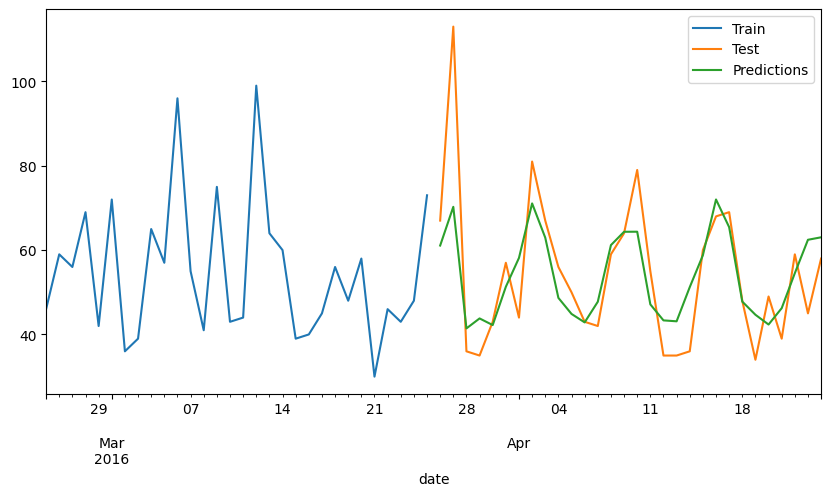

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()